## Prepare Dataset

In [1]:
import sys
sys.path.insert(1, '../datasets/')
from fasion_mnist import Dataset, DataLoader, TestDataloader
from fasion_mnist import IMAGE_SIZE, CHANNELS, BATCH_SIZE
dataset = Dataset()
dataloader = DataLoader()
test_dataloader = TestDataloader()

Found cached dataset fashion_mnist (/users/lukemk/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

## Prepare Models

In [2]:
import torch
from torch.optim import Adam
from models import Unet

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=IMAGE_SIZE,
    channels=CHANNELS,
    dim_mults=(1, 2, 4,)
).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

## Hyper-parameters

In [10]:
save_and_sample_every = 1000
timesteps = 200
scheduler_type = "linear"
from schedulers import Scheduler
scheduler = Scheduler(scheduler_type, timesteps = timesteps)

## Train

In [6]:
from torchvision.utils import save_image
from samplers import sample
from losses import p_losses
from utils import num_to_groups


epochs = 5

for epoch in range(epochs):
    epoch_loss = []
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, scheduler, batch, t, loss_type="huber")
        epoch_loss.append(loss.item())

        if step % 30 == 0:
            print("loss:", sum(epoch_loss) / len(epoch_loss), 'at step', step, ' out of ', len(dataloader))

        loss.backward()
        optimizer.step()

        # save generated images
        # if step != 0 and step % save_and_sample_every == 0:
        #     milestone = step // save_and_sample_every
        #     batches = num_to_groups(4, batch_size)
        #     all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        #     all_images = torch.cat(all_images_list, dim=0)
        #     all_images = (all_images + 1) * 0.5
        #     save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
    print(f'Loss after epoch {epoch}: {sum(epoch_loss) / len(epoch_loss)}')
    torch.save(model.state_dict(), f'../weights/fasion_mnist_Unet_param_ep{epoch}.pkl')

loss: 0.07411139458417892 at step 0  out of  469
loss: 0.05820540543044767 at step 30  out of  469
loss: 0.056727775723719204 at step 60  out of  469
loss: 0.05604862773811424 at step 90  out of  469
loss: 0.055887153202837166 at step 120  out of  469
loss: 0.05521060997583219 at step 150  out of  469
loss: 0.05513516298973758 at step 180  out of  469
loss: 0.054453224720548116 at step 210  out of  469
loss: 0.05406795641507845 at step 240  out of  469
loss: 0.05392948025322048 at step 270  out of  469
loss: 0.0536142355728387 at step 300  out of  469
loss: 0.0535752115900603 at step 330  out of  469
loss: 0.0533295434659703 at step 360  out of  469
loss: 0.0531825476499927 at step 390  out of  469
loss: 0.0529969540953353 at step 420  out of  469
loss: 0.0527787933625826 at step 450  out of  469
Loss after epoch 0: 0.05262069297688348
loss: 0.05178016796708107 at step 0  out of  469
loss: 0.04924495181729717 at step 30  out of  469
loss: 0.04895802465130071 at step 60  out of  469
los

## Load

In [ ]:
from torchvision.utils import save_image
from samplers import sample
from losses import p_losses
from utils import num_to_groups
from torch.utils.data import DataLoader, random_split
import time

import random
def evaluate (model):
    model.eval()
    total_loss = []
    start_time = time.time()
    
    for step, batch in enumerate(test_dataloader):
        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)
        t = torch.randint(0, scheduler.timesteps, (batch_size,), device=device).long()
        loss = p_losses(model, scheduler, batch, t, loss_type="huber")
        total_loss += [loss.item()]

    model.train()
    end_time = time.time()
    mean_loss = sum(total_loss) / len(total_loss)
    print(f'eval loss {mean_loss}, with run time {end_time - start_time}')
    return mean_loss

In [ ]:
linear = []
for i in range (10):
    name = f'../weights/fasion_mnist_Unet_linear_ep{i}.pkl'
    model.load_state_dict(torch.load(name))
    loss = evaluate(model)
    print(linear, loss)
    linear.append(loss)
    

import pickle
with open('../stats/fasion_mnist_Unet_linear.pkl', 'wb') as f:
    pickle.dump(linear, f)


In [6]:
cosine = []
for i in range (10):
    name = f'../weights/fasion_mnist_Unet_cosine_ep{i}.pkl'
    model.load_state_dict(torch.load(name))
    loss = evaluate(model)
    cosine.append(loss)
print(cosine)
import pickle
with open('../stats/fasion_mnist_Unet_cosine.pkl', 'wb') as f:
    pickle.dump(cosine, f)

eval loss 0.05162278062935117, with run time 9.276275396347046
eval loss 0.04330142328067671, with run time 6.246347665786743
eval loss 0.04040229876961889, with run time 6.239540100097656
eval loss 0.039642741738618176, with run time 6.208223342895508
eval loss 0.037928573150612134, with run time 6.264984369277954
eval loss 0.03653596692918977, with run time 6.3807618618011475
eval loss 0.0369840919311288, with run time 6.20477294921875
eval loss 0.03634539871370491, with run time 6.2087321281433105
eval loss 0.03563210111158558, with run time 6.230786085128784
eval loss 0.03533473830151407, with run time 6.23328161239624
[0.05162278062935117, 0.04330142328067671, 0.04040229876961889, 0.039642741738618176, 0.037928573150612134, 0.03653596692918977, 0.0369840919311288, 0.03634539871370491, 0.03563210111158558, 0.03533473830151407]


In [12]:
evaluate(model)

eval loss 0.03700185010704813, with run time 8.516544818878174


0.03700185010704813

## Visualize & Eval

sampling loop time step: 100%|██████████| 200/200 [00:05<00:00, 33.65it/s]


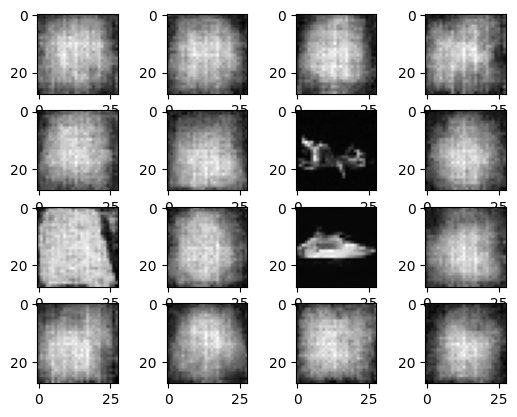

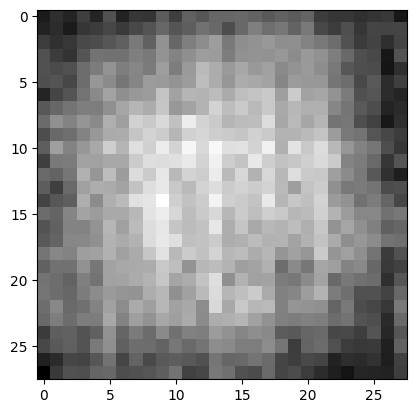

In [29]:
model.load_state_dict(torch.load('../weights/fasion_mnist_Unet_cosine_ep9.pkl'))
visualize(model, name_prefix = "loaded_cos")

In [11]:
from samplers import sample
%matplotlib inline
import matplotlib.pyplot as plt
from random import randrange
import matplotlib.animation as animation
import os

def make_animation(samples, index, name_prefix = ""):
    fig = plt.figure()
    ims = []
    for i in range(scheduler.timesteps):
        im = plt.imshow(samples[i][index].reshape(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), cmap="gray", animated=True)
        ims.append([im])
    animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    
    id = 0
    while os.path.exists(f'../gifs/{name_prefix}_{id}.gif'):
        id += 1
    animate.save(f'../gifs/{name_prefix}_{id}.gif')
    plt.show()

def visualize (model, gif_num = 1, side_num = 4, name_prefix = ""):
    samples = sample(model, scheduler, image_size=IMAGE_SIZE, batch_size = side_num * side_num, channels=CHANNELS)
    
    f, axarr = plt.subplots(side_num, side_num)
    for i in range(side_num):
        for j in range(side_num):
            axarr[i,j].imshow(samples[-1][i * side_num + j].reshape(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), cmap="gray")
    plt.show()

    # bottleneck is here
    for i in range(gif_num):
        make_animation(samples, i, name_prefix = name_prefix)

sampling loop time step: 100%|██████████| 200/200 [00:02<00:00, 72.58it/s]


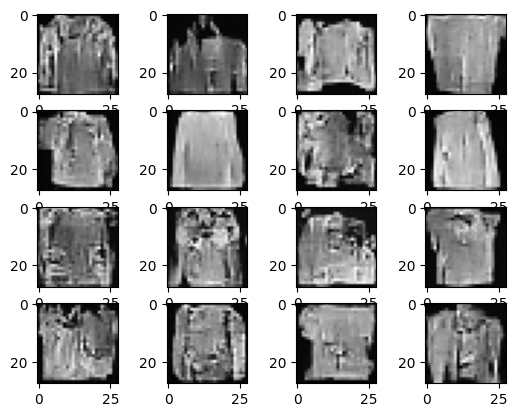

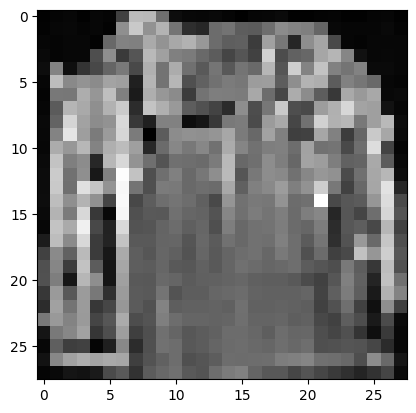

In [12]:
visualize(model, name_prefix = "test")